In [1]:
import torch
import torchvision
import seaborn as sns
sns.set_theme('notebook','white')

In [38]:
n_epochs = 3
batch_size_train = 4
batch_size_test = 4
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [39]:
train_loader = torch.utils.data.DataLoader(
torchvision.datasets.CIFAR10('./cifar/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))
                             ])),
  batch_size=batch_size_train, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./cifar/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

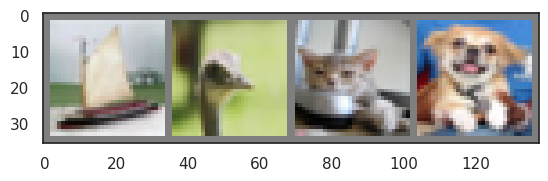

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('./images.png', dpi = 200, transparent = True)
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_train)))

In [42]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


net = Net()

In [43]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.190
[1,  4000] loss: 1.842
[1,  6000] loss: 1.675
[1,  8000] loss: 1.550
[1, 10000] loss: 1.521
[1, 12000] loss: 1.478
[2,  2000] loss: 1.405
[2,  4000] loss: 1.396
[2,  6000] loss: 1.359
[2,  8000] loss: 1.318
[2, 10000] loss: 1.311
[2, 12000] loss: 1.290
Finished Training


In [80]:
PATH = './cifar/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [85]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))



<All keys matched successfully>

/tmp/ipykernel_22575/3180818679.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


Brier score :  tensor(0.1325, dtype=torch.float64)
accuracy =  0 

Brier score :  tensor(0.1467, dtype=torch.float64)
accuracy =  0 

Brier score :  tensor(0.0002, dtype=torch.float64)
accuracy =  1 

Brier score :  tensor(0.0741, dtype=torch.float64)
accuracy =  0 



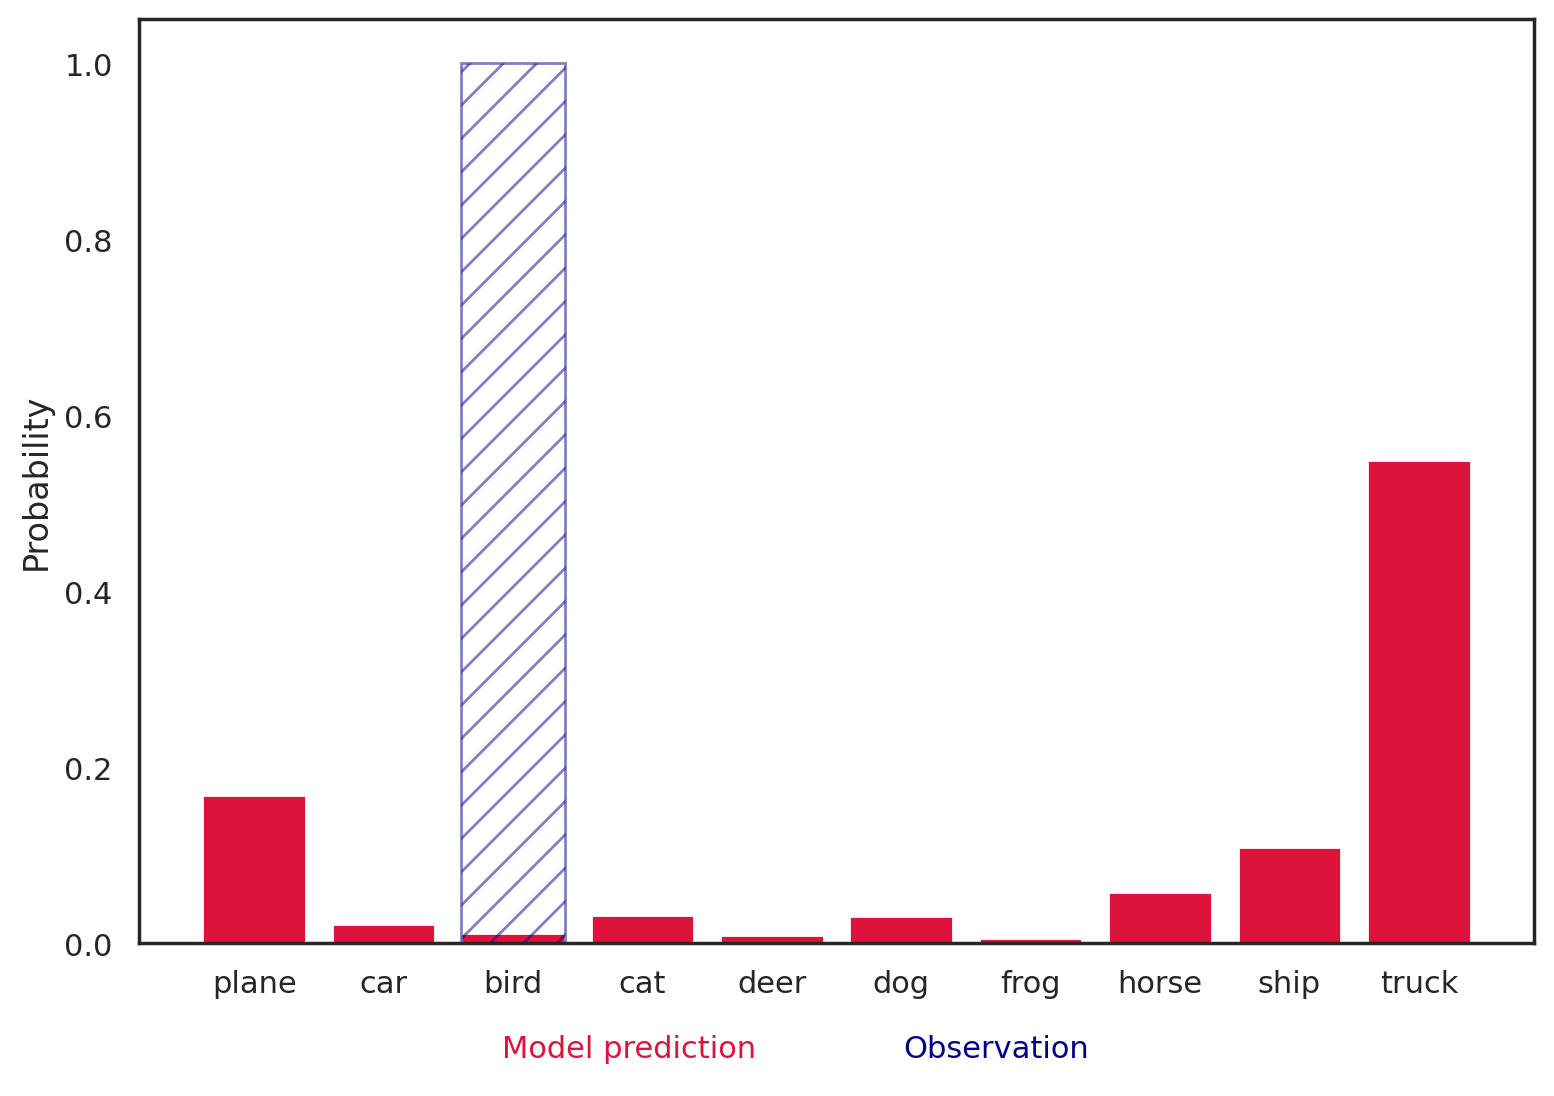

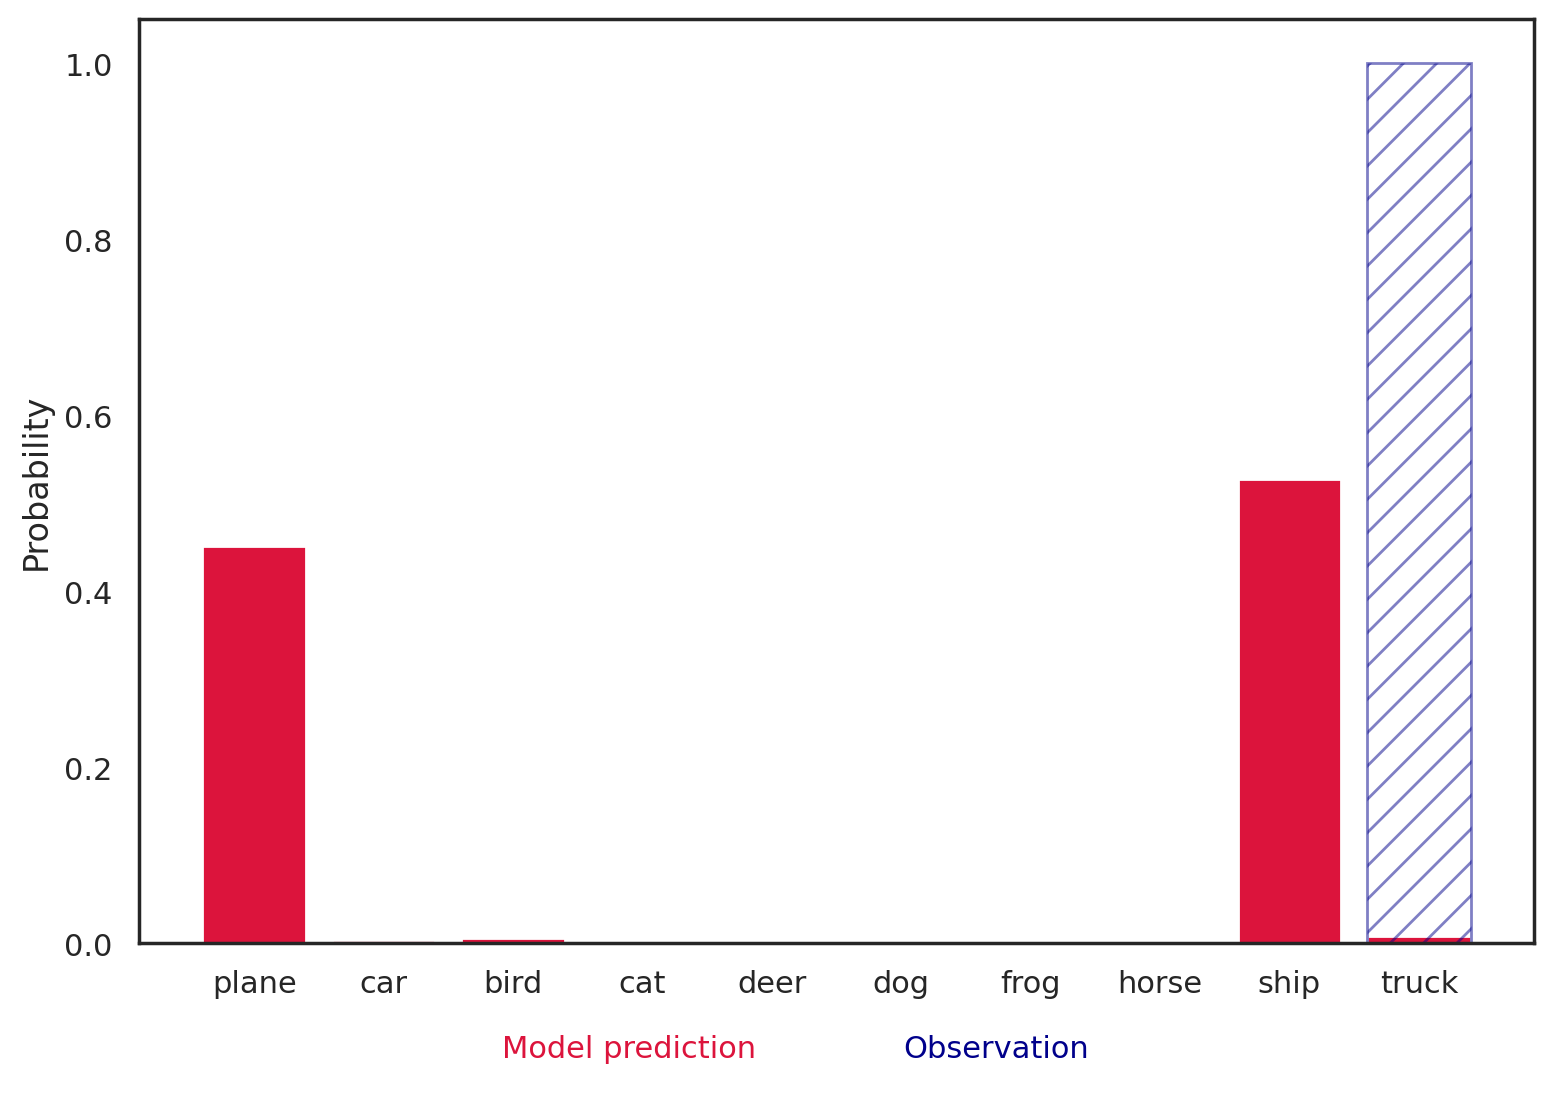

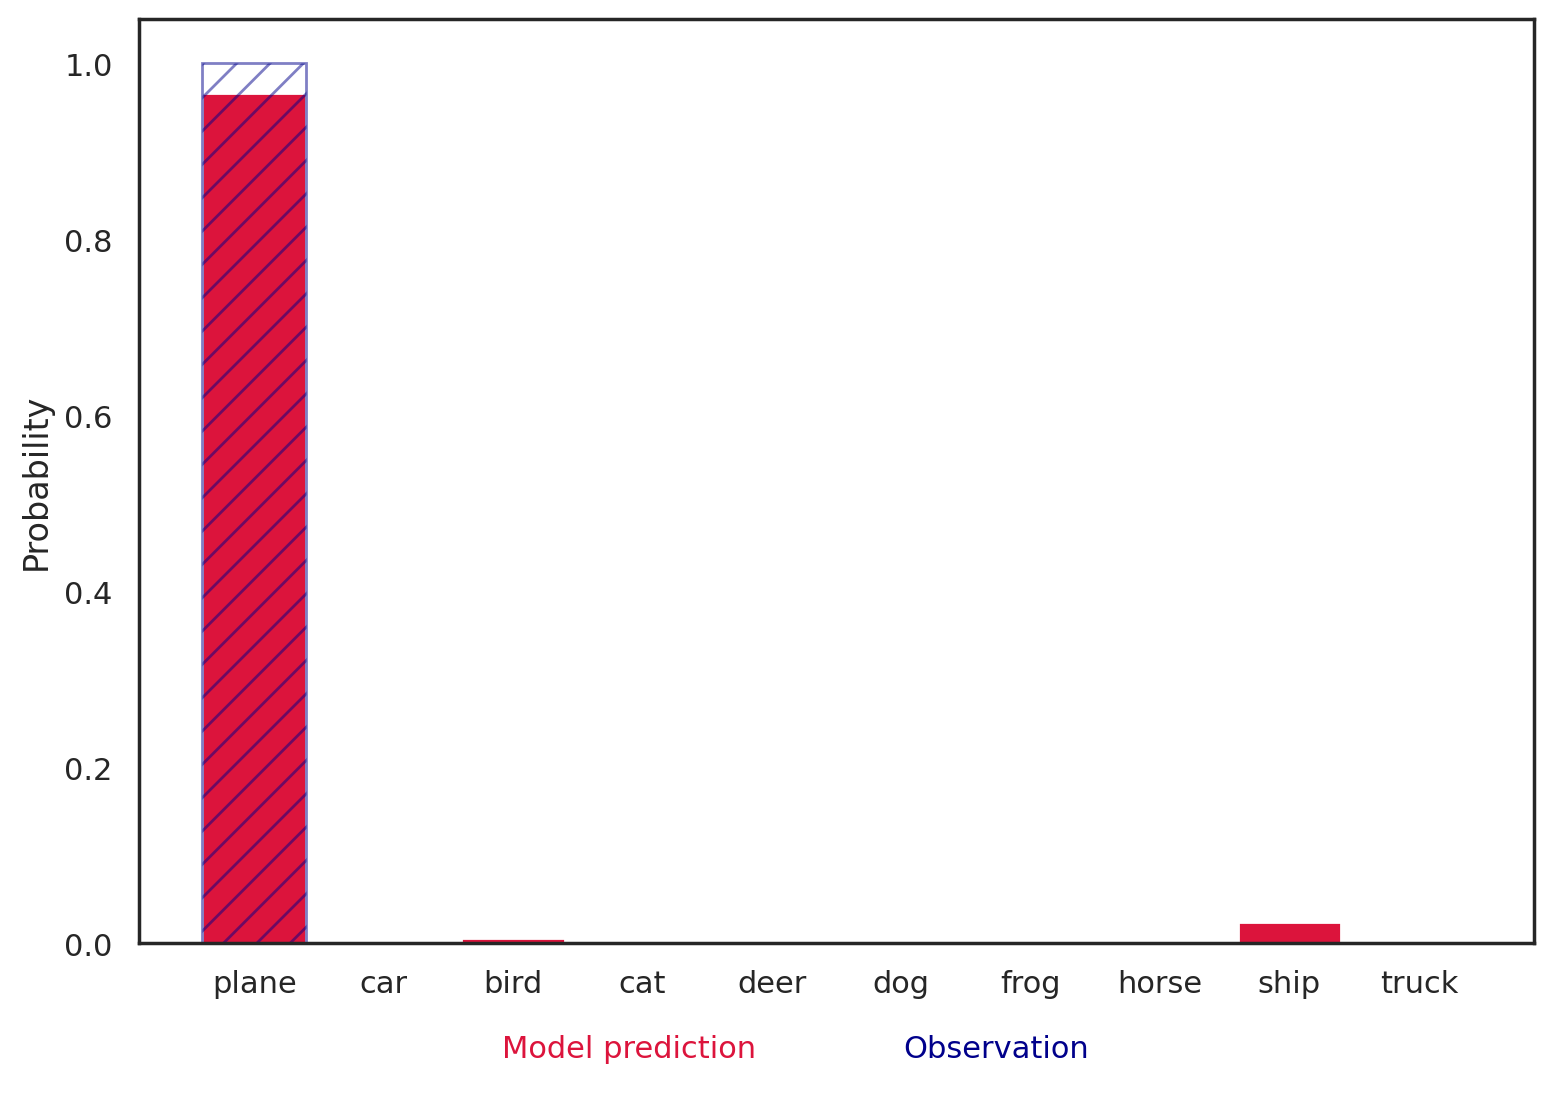

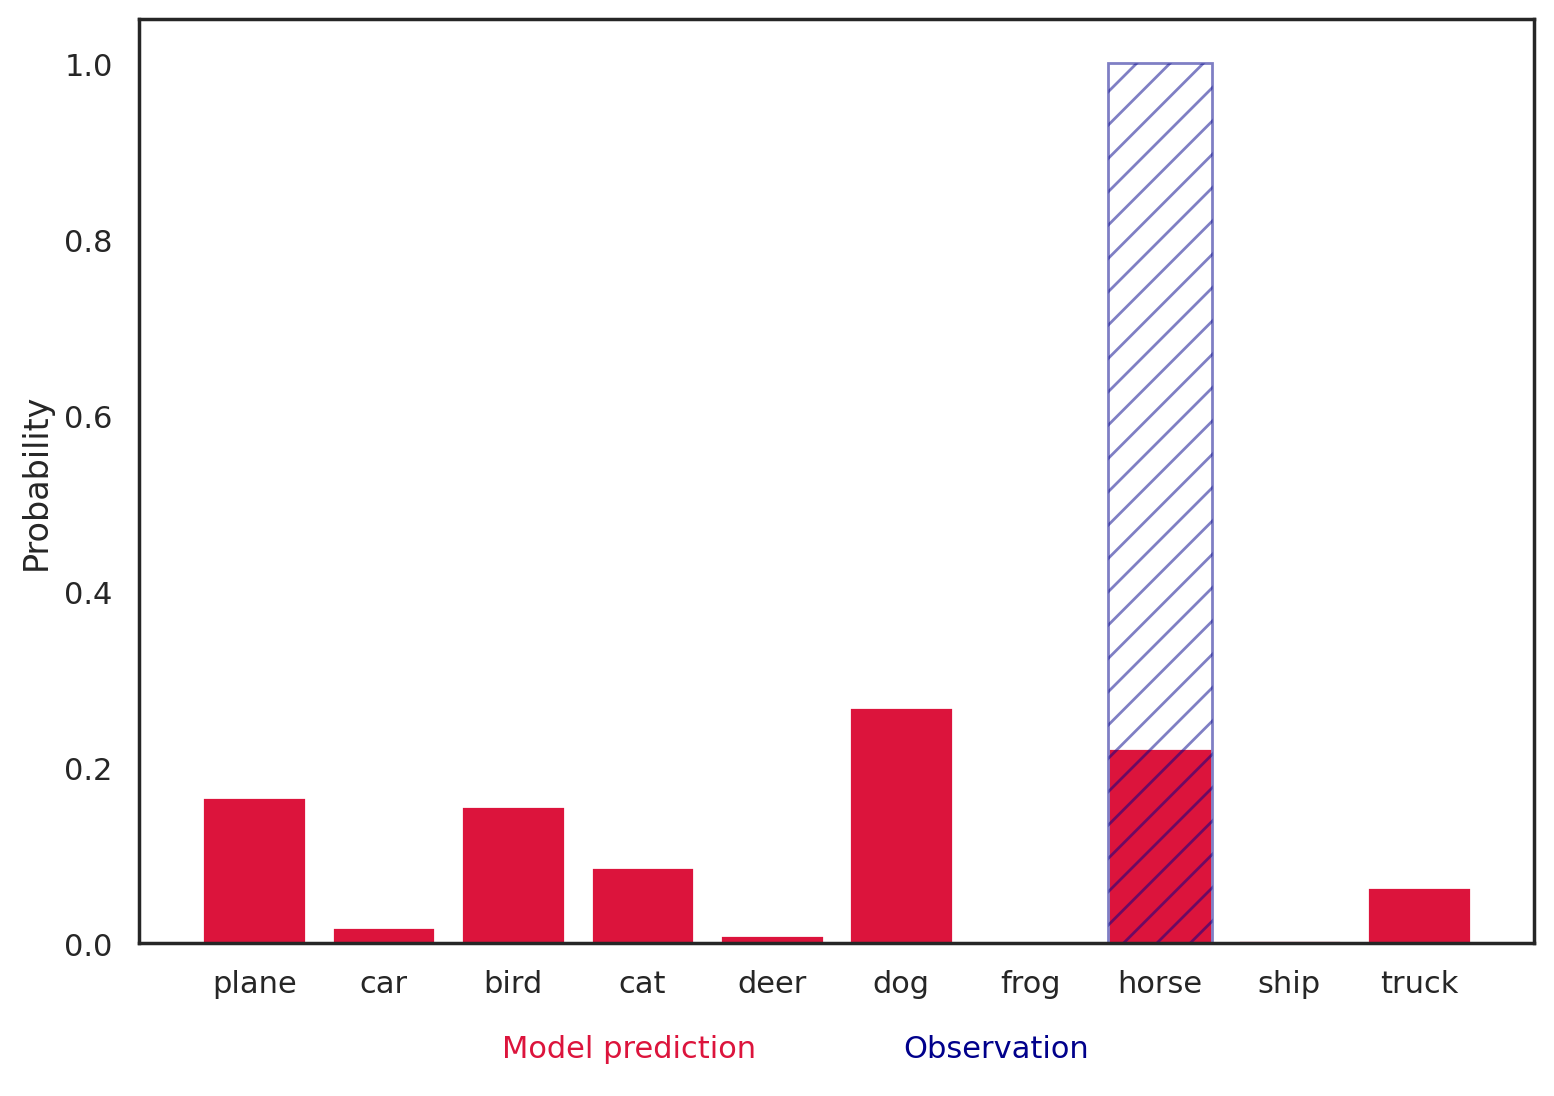

In [ ]:
logits = net(images)
probs = torch.exp(logits).detach()
trues = np.eye(10)[labels]
for i in range(4):
    plt.figure(figsize = (9,6), dpi = 200)
    plt.bar(x=classes,height=probs[i], color = 'crimson', label = 'model prediction')
    plt.bar(x=classes,height=trues[i],alpha = 0.5, width = .8, hatch = '//', fill = False,edgecolor = 'darkblue', label = 'observation')
    leg = plt.legend(['Model prediction', 'Observation'], loc='lower center', bbox_to_anchor=(0.44, -0.16), ncol = 3, frameon = False)
    plt.ylabel('Probability')
    for item in leg.legendHandles:
        item.set_visible(False)
    c = ['crimson', 'darkblue']
    print('Brier score : ', torch.mean((probs[i] - trues[i])**2))
    print('accuracy = ', int(int(torch.argmax(probs[i],axis = 0)) == np.argmax(trues[i], axis = 0)), '\n')
    for v,text in enumerate(leg.get_texts()) :
        text.set_color(c[v])
        text.set_size(11)
    plt.savefig(f'./prediction_{i}', dpi = 200, transparent = True, bbox_inches = 'tight')